## Graphs

In [1]:
import networkx as nx
G = nx.read_edgelist("karate.edgelist", nodetype=int)

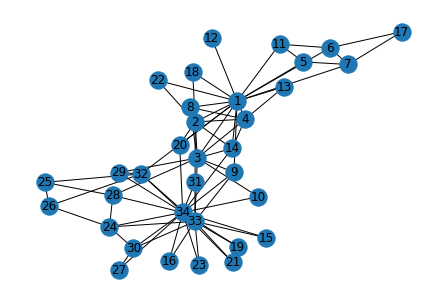

In [2]:
import networkx as nx

# Draw the graph
nx.draw(G, with_labels=True)


In [ ]:
from networkx.generators.random_graphs import erdos_renyi_graph


n = 500
p = 0.012
g1 = erdos_renyi_graph(n, p)

nx.draw(g1, with_labels=True)


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Read the edges CSV file into a pandas dataframe
df = pd.read_csv('/content/politician_edges.csv')

# Create a graph from the dataframe
G2 = nx.from_pandas_edgelist(df, 'node_1', 'node_2')

# Draw the graph
nx.draw(G2, with_labels=True)
plt.show()


# Greedy Approach

In [4]:
import networkx as nx
import random

def greedy_influence_maximization(G, k):
    """
    Greedy algorithm for influence maximization on a graph G.

    Args:
        G: a networkx graph object.
        k: the number of nodes to select.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """

    S = [] # Selected nodes
    for i in range(k):
        max_node = None
        max_influence = -1
        for node in G.nodes():
            if node not in S:
                influence = get_influence(G, S + [node])
                if influence > max_influence:
                    max_node = node
                    max_influence = influence
        S.append(max_node)
    return S

def get_influence(G, S):
    """
    Compute the spread of influence on a graph G starting from a set of seed nodes S.

    Args:
        G: a networkx graph object.
        S: a list of seed nodes.

    Returns:
        The number of nodes influenced by S.
    """

    H = nx.Graph(G) # Copy the original graph
    for node in S:
        H.nodes[node]['activated'] = True # Activate the seed nodes

    activated_nodes = set(S)
    while True:
        activated_nodes_old = set(activated_nodes)
        for node in activated_nodes_old:
            for neighbor in H.neighbors(node):
                if not H.nodes[neighbor].get('activated', False):
                    # Check if the neighbor is influenced
                    num_activated_neighbors = sum(1 for n in H.neighbors(neighbor) if H.nodes[n].get('activated', False))
                    if random.random() < 1 - (1 - H[node][neighbor]['weight']) ** num_activated_neighbors:
                        H.nodes[neighbor]['activated'] = True
                        activated_nodes.add(neighbor)
        if activated_nodes == activated_nodes_old:
            break
    return len(activated_nodes)


In [5]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in G.edges():
    G[u][v]['weight'] = 1

# Run the greedy algorithm
k = 5
S = greedy_influence_maximization(G, k)

# Print the selected nodes
print(S)


[1, 32, 22, 20, 18]
Wall time: 168 ms


In [6]:
import networkx as nx
import random

def independent_cascade(G, seeds, p):
    # Set the initial active nodes to the seed nodes
    active_nodes = list(seeds)
    
    # Set the initial round to 0
    round = 0
    
    # Repeat until no more nodes can become active
    while True:
        # Set the nodes that became active in this round to an empty set
        newly_active_nodes = set()
        
        # For each active node
        for node in active_nodes:
            # For each of its neighbors that is not already active
            for neighbor in G.neighbors(node):
                if neighbor not in active_nodes and neighbor not in newly_active_nodes:
                    # Add the neighbor to the set of newly active nodes with probability p
                    if random.random() < p:
                        newly_active_nodes.add(neighbor)
        
        # If no nodes became active in this round, exit the loop
        if not newly_active_nodes:
            break
        
        # Add the newly active nodes to the set of active nodes
        active_nodes.extend(list(newly_active_nodes))
        
        # Increment the round counter
        round += 1
    
    # Return the number of nodes that became active during the simulation
    return len(active_nodes)


In [8]:
seeds = S
Spread1 = independent_cascade(G, seeds, 0.1)
Spread1


27

In [ ]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in g1.edges():
    g1[u][v]['weight'] = 1

# Run the greedy algorithm
k = 20
S = greedy_influence_maximization(g1, k)

# Print the selected nodes
print(S)

# CELF Algo

In [ ]:
import networkx as nx
import heapq

def celf_influence_maximization(G, k):
    """
    CELF algorithm for influence maximization on a graph G.

    Args:
        G: a networkx graph object.
        k: the number of nodes to select.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """
    
    S = [] # Selected nodes
    pq = [] # Priority queue of candidate nodes
    
    # Compute the marginal gain of each node
    for node in G.nodes():
        mg = get_marginal_gain(G, S, node)
        heapq.heappush(pq, (-mg, node))
        
    # Select the top k nodes with highest marginal gain
    while len(S) < k:
        _, node = heapq.heappop(pq)
        S.append(node)
        # Update the priority queue with the new marginal gains
        for neighbor in G.neighbors(node):
            if neighbor not in S:
                mg = get_marginal_gain(G, S, neighbor)
                heapq.heappush(pq, (-mg, neighbor))
                
    return S

def get_marginal_gain(G, S, node):
    """
    Compute the marginal gain of adding a node to a set of seed nodes.

    Args:
        G: a networkx graph object.
        S: a list of seed nodes.
        node: the node to evaluate.

    Returns:
        The marginal gain of adding the node to the seed nodes.
    """
    
    if node in S:
        return 0
    
    H = nx.Graph(G) # Copy the original graph
    for n in S:
        H.nodes[n]['activated'] = True # Activate the seed nodes
    
    # Compute the initial number of activated nodes
    activated_nodes = set(S)
    for n in nx.descendants(H, node):
        if not H.nodes[n].get('activated', False):
            num_activated_neighbors = sum(1 for m in H.neighbors(n) if H.nodes[m].get('activated', False))
            if random.random() < H[n][m]['weight'] ** num_activated_neighbors:
                H.nodes[n]['activated'] = True
                activated_nodes.add(n)
    initial_influence = len(activated_nodes)
    
    # Compute the number of activated nodes with the node added
    H.nodes[node]['activated'] = True
    activated_nodes.add(node)
    for n in nx.descendants(H, node):
        if not H.nodes[n].get('activated', False):
            num_activated_neighbors = sum(1 for m in H.neighbors(n) if H.nodes[m].get('activated', False))
            if random.random() < H[n][m]['weight'] ** num_activated_neighbors:
                H.nodes[n]['activated'] = True
                activated_nodes.add(n)
    influence = len(activated_nodes)
    
    return influence - initial_influence


In [ ]:
import networkx as nx
import heapq

def celf_influence_maximization(G, k):
    """
    CELF algorithm for influence maximization on a graph G.

    Args:
        G: a networkx graph object.
        k: the number of nodes to select.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """
    
    S = [] # Selected nodes
    pq = [] # Priority queue of candidate nodes
    
    # Compute the marginal gain of each node
    for node in G.nodes():
        mg = get_marginal_gain(G, S, node)
        heapq.heappush(pq, (-mg, node))
        
    # Select the top k nodes with highest marginal gain
    while len(S) < k:
        _, node = heapq.heappop(pq)
        S.append(node)
        # Update the priority queue with the new marginal gains
        for neighbor in G.neighbors(node):
            if neighbor not in S:
                mg = get_marginal_gain(G, S, neighbor)
                heapq.heappush(pq, (-mg, neighbor))
                
    return S

def get_marginal_gain(G, S, node):
    """
    Compute the marginal gain of a node given a set of seed nodes S.

    Args:
        G: a networkx graph object.
        S: a list of seed nodes.
        node: the node to evaluate.

    Returns:
        The marginal gain of the node.
    """
    
    if node in S:
        return 0
    
    H = nx.Graph(G) # Copy the original graph
    for n in S:
        H.remove_node(n) # Remove the seed nodes
    
    # Compute the influence spread of the node
    activated_nodes = set([node])
    while True:
        activated_nodes_prev = activated_nodes.copy()
        for n in activated_nodes_prev:
            for m in H.neighbors(n):
                if m not in activated_nodes:
                    if random.random() < H[n][m]['weight']:
                        activated_nodes.add(m)
        if activated_nodes == activated_nodes_prev:
            break
    influence = len(activated_nodes)
    
    # Compute the marginal gain
    return influence - len(S)


In [ ]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in G.edges():
    G[u][v]['weight'] = 1

# Run the CELF algorithm
k = 5
S = celf_influence_maximization(G, k)

# Print the selected nodes
print(S)

In [ ]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in g1.edges():
    g1[u][v]['weight'] = 1

# Run the CELF algorithm
k = 20
S = celf_influence_maximization(g1, k)

# Print the selected nodes
print(S)

# CELF++

In [ ]:
import networkx as nx
from queue import PriorityQueue

def celfpp_influence_maximization(G, k):
    """
    CELF++ algorithm for influence maximization on a graph G.

    Args:
        G: a networkx graph object.
        k: the number of nodes to select.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """
    
    S = [] # Selected nodes
    pq = PriorityQueue() # Priority queue of candidate nodes
    
    # Compute the marginal gain of each node
    for node in G.nodes():
        mg = get_marginal_gain(G, S, node)
        pq.put((-mg, node))
        
    # Select the top k nodes with highest marginal gain
    while len(S) < k:
        while True:
            _, node = pq.get()
            if node not in S:
                S.append(node)
                break
        # Update the priority queue with the new marginal gains
        for neighbor in G.neighbors(node):
            if neighbor not in S:
                new_mg = get_marginal_gain(G, S, neighbor)
                if new_mg > 0:
                    old_mg = -pq.queue[-1][0] if pq.qsize() == k else 0
                    if new_mg > old_mg:
                        pq.put((-new_mg, neighbor))
                        if pq.qsize() > k:
                            pq.get()
                
    return S

def get_marginal_gain(G, S, node):
    """
    Compute the marginal gain in influence of a node given a set of seed nodes S.

    Args:
        G: a networkx graph object.
        S: a list of seed nodes.
        node: the node to evaluate.

    Returns:
        The marginal gain in influence of the node.
    """
    
    if node in S:
        return 0
    
    H = nx.Graph(G) # Copy the original graph
    for n in S:
        H.nodes[n]['activated'] = True # Activate the seed nodes
    
    # Compute the initial number of activated nodes
    activated_nodes = set(S)
    for n in nx.descendants(H, node):
        if not H.nodes[n].get('activated', False):
            num_activated_neighbors = sum(1 for m in H.neighbors(n) if H.nodes[m].get('activated', False))
            if random.random() < 1 - (1 - H[n][m]['weight']) ** num_activated_neighbors:
                H.nodes[n]['activated'] = True
                activated_nodes.add(n)
    initial_influence = len(activated_nodes)
    
    # Compute the number of activated nodes with the node added
    H.nodes[node]['activated'] = True
    activated_nodes.add(node)
    for n in nx.descendants(H, node):
        if not H.nodes[n].get('activated', False):
            num_activated_neighbors = sum(1 for m in H.neighbors(n) if H.nodes[m].get('activated', False))
            if random.random() < 1 - (1 - H[n][m]['weight']) ** num_activated_neighbors:
                H.nodes[n]['activated'] = True
                activated_nodes.add(n)
    influence = len(activated_nodes)
    
    return influence - initial_influence


In [ ]:
import networkx as nx
from queue import PriorityQueue

def celfpp_influence_maximization(G, k):
    """
    CELF++ algorithm for influence maximization on a graph G.

    Args:
        G: a networkx graph object.
        k: the number of nodes to select.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """
    
    S = [] # Selected nodes
    pq = PriorityQueue() # Priority queue of candidate nodes
    
    # Compute the marginal gain of each node
    for node in G.nodes():
        mg = get_marginal_gain(G, S, node)
        pq.put((-mg, node))
        
    # Select the top k nodes with highest marginal gain
    while len(S) < k:
        while True:
            _, node = pq.get()
            if node not in S:
                S.append(node)
                break
        # Update the priority queue with the new marginal gains
        for neighbor in G.neighbors(node):
            if neighbor not in S:
                new_mg = get_marginal_gain(G, S, neighbor)
                if new_mg > 0:
                    old_mg = -pq.queue[-1][0] if pq.qsize() == k else 0
                    if new_mg > old_mg:
                        pq.put((-new_mg, neighbor))
                        if pq.qsize() > k:
                            pq.get()
                
    return S
def get_marginal_gain(G, S, node):
    """
    Compute the marginal gain of a node given a set of seed nodes S.

    Args:
        G: a networkx graph object.
        S: a list of seed nodes.
        node: the node to evaluate.

    Returns:
        The marginal gain of the node.
    """
    
    if node in S:
        return 0
    
    H = nx.Graph(G) # Copy the original graph
    for n in S:
        H.remove_node(n) # Remove the seed nodes
    
    # Compute the influence spread of the node
    activated_nodes = set([node])
    while True:
        activated_nodes_prev = activated_nodes.copy()
        for n in activated_nodes_prev:
            for m in H.neighbors(n):
                if m not in activated_nodes:
                    if random.random() < H[n][m]['weight']:
                        activated_nodes.add(m)
        if activated_nodes == activated_nodes_prev:
            break
    influence = len(activated_nodes)
    
    # Compute the marginal gain
    return influence - len(S)


In [ ]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in G.edges():
    G[u][v]['weight'] = 1

# Run the CELF++ algorithm
k = 5
S = celfpp_influence_maximization(G, k)

# Print the selected nodes
print(S)

In [ ]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in g1.edges():
    g1[u][v]['weight'] = 1

# Run the CELF++ algorithm
k = 20
S = celfpp_influence_maximization(g1, k)

# Print the selected nodes
print(S)

In [ ]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in G2.edges():
    G2[u][v]['weight'] = 1

# Run the CELF++ algorithm
k = 25
S = celfpp_influence_maximization(G2, k)

# Print the selected nodes
print(S)

# CELFIE

In [ ]:
import networkx as nx
import heapq

def celfie_influence_maximization(G, k, alpha):
    """
    CELFIE algorithm for influence maximization on a graph G.

    Args:
        G: a networkx graph object.
        k: the number of nodes to select.
        alpha: the scaling parameter for the influence estimation.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """
    
    S = [] # Selected nodes
    pq = [] # Priority queue of candidate nodes
    
    # Compute the influence estimation of each node
    for node in G.nodes():
        ie = get_influence_estimation(G, S, node, alpha)
        heapq.heappush(pq, (-ie, node))
        
    # Select the top k nodes with highest influence estimation
    while len(S) < k:
        _, node = heapq.heappop(pq)
        S.append(node)
        # Update the priority queue with the new influence estimations
        for neighbor in G.neighbors(node):
            if neighbor not in S:
                ie = get_influence_estimation(G, S, neighbor, alpha)
                heapq.heappush(pq, (-ie, neighbor))
                
    return S

def get_influence_estimation(G, S, node, alpha):
    """
    Compute the influence estimation of a node given a set of seed nodes S.

    Args:
        G: a networkx graph object.
        S: a list of seed nodes.
        node: the node to evaluate.
        alpha: the scaling parameter for the influence estimation.

    Returns:
        The influence estimation of the node.
    """
    
    if node in S:
        return 0
    
    H = nx.Graph(G) # Copy the original graph
    for n in S:
        H.nodes[n]['activated'] = True # Activate the seed nodes
    
    # Compute the initial number of activated nodes
    activated_nodes = set(S)
    for n in nx.descendants(H, node):
        if not H.nodes[n].get('activated', False):
            num_activated_neighbors = sum(1 for m in H.neighbors(n) if H.nodes[m].get('activated', False))
            if random.random() < (1 - alpha) * (1 - H[n][m]['weight']) ** num_activated_neighbors:
                H.nodes[n]['activated'] = True
                activated_nodes.add(n)
    initial_influence = len(activated_nodes)
    
    # Compute the number of activated nodes with the node added
    H.nodes[node]['activated'] = True
    activated_nodes.add(node)
    for n in nx.descendants(H, node):
        if not H.nodes[n].get('activated', False):
            num_activated_neighbors = sum(1 for m in H.neighbors(n) if H.nodes[m].get('activated', False))
            if random.random() < (1 - alpha) * (1 - H[n][m]['weight']) ** num_activated_neighbors:
                H.nodes[n]['activated'] = True
                activated_nodes.add(n)
    influence = len(activated_nodes)
    
    return influence - initial_influence


In [ ]:
import networkx as nx
import heapq

def celfie_influence_maximization(G, k, alpha=0.1):
    """
    CELFIE algorithm for influence maximization on a graph G.

    Args:
        G: a networkx graph object.
        k: the number of nodes to select.
        alpha: the scaling factor for the influence estimation.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """
    
    S = [] # Selected nodes
    pq = [] # Priority queue of candidate nodes
    
    # Compute the marginal gain and influence estimate of each node
    for node in G.nodes():
        mg, ie = get_marginal_gain_and_influence_estimate(G, S, node, alpha)
        heapq.heappush(pq, (-mg, node, ie))
        
    # Select the top k nodes with highest marginal gain
    while len(S) < k:
        _, node, ie = heapq.heappop(pq)
        S.append(node)
        # Update the priority queue with the new marginal gains and influence estimates
        for neighbor in G.neighbors(node):
            if neighbor not in S:
                mg, ie = get_marginal_gain_and_influence_estimate(G, S, neighbor, alpha)
                heapq.heappush(pq, (-mg, neighbor, ie))
                
    return S

def get_marginal_gain_and_influence_estimate(G, S, node, alpha):
    """
    Compute the marginal gain and influence estimate of adding a node to a set of seed nodes.

    Args:
        G: a networkx graph object.
        S: a list of seed nodes.
        node: the node to evaluate.
        alpha: the scaling factor for the influence estimation.

    Returns:
        A tuple containing the marginal gain and influence estimate of adding the node to the seed nodes.
    """
    
    if node in S:
        return 0, 0
    
    H = nx.Graph(G) # Copy the original graph
    for n in S:
        H.nodes[n]['activated'] = True # Activate the seed nodes
    
    # Compute the initial number of activated nodes
    activated_nodes = set(S)
    for n in nx.descendants(H, node):
        if not H.nodes[n].get('activated', False):
            num_activated_neighbors = sum(1 for m in H.neighbors(n) if H.nodes[m].get('activated', False))
            for m in H.neighbors(n):
              if random.random() < (H[n][m]['weight'] ** num_activated_neighbors) ** alpha:
                H.nodes[n]['activated'] = True
                activated_nodes.add(n)
    initial_influence = len(activated_nodes)
    
    # Compute the number of activated nodes with the node added
    H.nodes[node]['activated'] = True
    activated_nodes.add(node)
    for n in nx.descendants(H, node):
        if not H.nodes[n].get('activated', False):
            num_activated_neighbors = sum(1 for m in H.neighbors(n) if H.nodes[m].get('activated', False))
            for m in H.neighbors(n):
              if random.random() < (H[n][m]['weight'] ** num_activated_neighbors) ** alpha:
                H.nodes[n]['activated'] = True
                activated_nodes.add(n)
    influence = len(activated_nodes)
    
    # Compute the influence estimate
    ie = (influence - initial_influence) / alpha + initial_influence
    
    # Compute the marginal gain
    mg = ie - len(S)
    
    return mg, ie


In [ ]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in G.edges():
    G[u][v]['weight'] = 1

# Run the CELFIE algorithm
k = 5
alpha = 0.1
S = celfie_influence_maximization(G, k, alpha)

# Print the selected nodes
print(S)

In [ ]:
%%time
import networkx as nx

# Set the weights of the edges (optional)
for u, v in g1.edges():
    g1[u][v]['weight'] = 1

# Run the CELFIE algorithm
k = 20
alpha = 0.1
S = celfie_influence_maximization(g1, k, alpha)

# Print the selected nodes
print(S)

## Meterics

## With embeddings

In [ ]:
import pandas as pd
emb = pd.read_csv("politician_embedding.csv")
emb

In [ ]:
edges = pd.read_csv("/content/politician_edges.csv")
edges